# 神经网络

载入一些库：

In [5]:
def set_env(num, current_path='.'):
    import sys
    from pathlib import Path

    ROOT = Path(current_path).resolve().parents[num]
    sys.path.extend([str(ROOT/'src')]) # 设置 `tvm_book` 环境
    from tvm_book.contrib.tvm import set_env # 设置 TVM 环境

set_env(1)
from tvm_book.contrib import d2ltvm

import numpy as np
import mxnet as mx
from PIL import Image
import tvm
from tvm import relay

In [6]:
model_name = 'vgg11'

model = mx.gluon.model_zoo.vision.get_model(model_name, pretrained=True)
# len(model.features), model.output

(25, Dense(4096 -> 1000, linear))

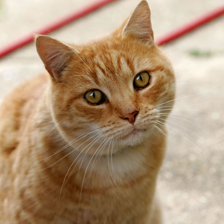

In [7]:
ROOT = '../origin/d2l-tvm'

import gluoncv as gcv
imagenet_attr = gcv.data.ImageNet1kAttr()
labels = imagenet_attr.classes_long
# with open(f'{ROOT}/data/imagenet1k_labels.txt') as f:
#     labels = eval(f.read())

image = Image.open(f'{ROOT}/data/cat.jpg').resize((224, 224))
image

In [8]:
x = d2ltvm.image_preprocessing(image)
x.shape

(1, 3, 224, 224)

In [9]:
input_name = 'data'
relay_mod, relay_params = relay.frontend.from_mxnet(model, {input_name: x.shape})
type(relay_mod), type(relay_params)

(tvm.ir.module.IRModule, dict)

In [10]:
target = 'llvm'
# 将模型与标准优化一起构建成 TVM 库
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(relay_mod, target, params=relay_params)

lib

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


In [11]:
ctx = tvm.device(target, 0)
module = tvm.contrib.graph_executor.GraphModule(lib["default"](ctx))
module

In [12]:
dtype = "float32"
module.set_input(input_name, x)
module.run()
output_shape = (1, 1000)
tvm_output = module.get_output(0, tvm.nd.empty(output_shape)).numpy()
tvm_output.shape

(1, 1000)

In [13]:
scores = tvm_output[0]
a = np.argsort(scores)[-1:-5:-1]
labels[a[0]], labels[a[1]]

('tiger cat', 'Egyptian cat')

In [14]:
!rm -rf outputs/*
graph_fn, mod_fn, params_fn = ['outputs/'+model_name+ext for ext in ('.json','.tar','.params')]
lib.export_library(mod_fn)
with open(graph_fn, 'w') as f:
    f.write(lib.graph_json)
with open(params_fn, 'wb') as f:
    f.write(relay.save_param_dict(lib.params))

!ls -alht outputs/*

-rw-rw-r-- 1 pc pc 507M 4月  24 13:49 outputs/vgg11.params
-rw-rw-r-- 1 pc pc  20K 4月  24 13:49 outputs/vgg11.json
-rw-rw-r-- 1 pc pc 471M 4月  24 13:49 outputs/vgg11.tar


In [15]:
loaded_graph = open(graph_fn).read()
loaded_mod = tvm.runtime.load_module(mod_fn)
loaded_params = open(params_fn, "rb").read()

In [1]:
import torch

In [ ]:
torch.quantization.get_default_qconfig